https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?

https://github.com/jagtapraj123/COVID-19_Research_Paper_Ranking_NLP/blob/master/COVID-19%20All%20Methods.ipynb

In [9]:
import numpy as np 
import pandas as pd
import glob
import json
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from collections import Counter

from tqdm import tqdm
!pip install langdetect
from langdetect import detect

In [10]:
root_path = '/Users/sdeshpande/Desktop/bioinformatices/COVID-19_data/'
all_json = glob.glob(f'{root_path}document_parses/**/*.json', recursive=True)
print('Total number of papers : {}'.format(len(all_json)))

Total number of papers : 172252


In [11]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            self.title = content['metadata']['title']
            self.authors = ''
            for author in content['metadata']['authors']:
                #concatenate first name and last name
                self.authors += author['first'] + ' ' + author['last'] + ", "
            #removing last comma and a space from string authors
            self.authors = self.authors[:-2]
            # Abstract
            try:
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            except:
                self.abstract = []
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            #converting list to string
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

    
# first_row = FileReader(all_json[0])
# print(first_row)

In [12]:
def read_dataset(all_json):
    dict_ = {'paper_id': [],  'title': [], 'authors': [], 'abstract': [], 'body_text': []}
    for idx, entry in enumerate(tqdm(all_json)):
#         if idx % (len(all_json) // 10) == 0:
#             print(f'Processing index: {idx} of {len(all_json)}')
        content = FileReader(entry)
        dict_['paper_id'].append(content.paper_id)
        dict_['title'].append(content.title)
        dict_['authors'].append(content.authors)
        dict_['abstract'].append(content.abstract)
        dict_['body_text'].append(content.body_text)
    df_dataset = pd.DataFrame(dict_, columns=['paper_id', 'title', 'authors', 'abstract', 'body_text'])
    return df_dataset

In [13]:
df_covid = read_dataset(all_json[:15000])
df_covid.head()

100%|██████████| 15000/15000 [00:18<00:00, 814.90it/s] 


,paper_id,title,authors,abstract,body_text
0,PMC7405720,Potential of combating transmission of COVID-1...,"Assem Elzaabalawy, S. Meguid",,COVID-19 can be transmitted through airborne r...
1,PMC7091850,The impact of COVID-19 on the provision of don...,"Jeff Szer, Daniel Weisdorf, Sergio Querol, Lyd...",,The provision of donors for life-saving hemato...
2,PMC7188043,The Response of the Anesthesia & Analgesia Com...,"Thomas Vetter, Jean-François Pittet",,"Name: Thomas R. Vetter, MD, MPH.\nContribution..."
3,PMC7194468,Recent advances in influenza vaccines,"Graham Pawelec, Janet McElhaney",,Despite the common perception that it is “only...
4,PMC7096991,Guarding the frontiers: the biology of type II...,"Andreas Wack, Ewa Terczyńska-Dyla, Rune Hartmann",,The type III IFN family was discovered by two ...


In [14]:
def dataset_cleanup(df_dataset):
    print("Cleaning Dataset")
    try:
        df_dataset.drop_duplicates(['abstract', 'filtered_body_text'], inplace=True)
    except:
        df_dataset.drop_duplicates(['abstract', 'body_text'], inplace=True)
    df_dataset.dropna(inplace=True)
    return df_dataset

In [15]:
def text_filtering(df_dataset):
    df_dataset['filtered_body_text'] = df_dataset['body_text'].copy()# change this back to body-text
    #remove square bracket contents
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub('\[.*?\]','',x))
    print('square bracket contents removal done')
    #remove parenthesis contents
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub('\(.*?\)','',x))
    print('parenthesis contents removal done')
    #remove punctuation except hyphen
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s-]','',x))
    print('punctuation removal done')
    #remove \n \t
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub('\n|\t',' ',x))
    print('\\n \\t removal done')
    #remove extra space
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: re.sub(' +',' ',x))
    print('extra space removal done')
#     remove non alpha numeric
#     df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: "".join(filter(str.isalnum, x)))
#     print('non alpha numeric removal done')
    # make everything lower case
    df_dataset['filtered_body_text'] = df_dataset['filtered_body_text'].apply(lambda x: x.lower())
    print('everything made lowercase')
    return df_dataset

In [16]:
def filter_english(df_dataset, show_ignored=False):
    print("Filtering English Documents")
    ignore_idxs = []
    for i in tqdm(range(df_dataset.shape[0])):
        try:
            if not detect(df_dataset.iloc[i]['filtered_body_text'][:]) == "en":
                ignore_idxs.append(i)
        except:
            ignore_idxs.append(i)

#     for i in range(df_dataset.shape[0]):
#         if ' the ' not in df_dataset.iloc[i]['filtered_body_text']:
#             ignore_idxs.append(i)
    
    if show_ignored:
        for i in ignore_idxs[:10]:
            print (df_dataset.iloc[i]['filtered_body_text'][:250]+"......")
            print("="*140)
            
    df_dataset.drop(df_dataset.index[ignore_idxs], inplace=True)
    return df_dataset

In [17]:
def remove_small_papers(df_dataset, show_ignored=False):
    ignore_idxs = []
    for i in tqdm(range(df_dataset.shape[0])):
        if len(df_covid_small.iloc[i]['filtered_body_text']) < 500:
                ignore_idxs.append(i)
    if show_ignored:
        for i in ignore_idxs[:10]:
            print (df_dataset.iloc[i]['filtered_body_text'][:250]+"......")
            print("="*140)
    df_dataset.drop(df_dataset.index[ignore_idxs], inplace=True)
    return df_dataset

In [18]:
df_covid = dataset_cleanup(df_covid)
df_covid.info()

Cleaning Dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14827 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   14827 non-null  object
 1   title      14827 non-null  object
 2   authors    14827 non-null  object
 3   abstract   14827 non-null  object
 4   body_text  14827 non-null  object
dtypes: object(5)
memory usage: 695.0+ KB


In [19]:
df_covid_small = df_covid.head(10000).copy()
# df_covid_small = df_covid.copy()

In [20]:
df_covid_small = text_filtering(df_covid_small)
df_covid_small = dataset_cleanup(df_covid_small)
df_covid_small = remove_small_papers(df_covid_small)
df_covid_small = filter_english(df_covid_small)
df_covid_small = dataset_cleanup(df_covid_small)

square bracket contents removal done
parenthesis contents removal done
punctuation removal done
\n \t removal done
extra space removal done
everything made lowercase
Cleaning Dataset


  0%|          | 0/9635 [00:00<?, ?it/s]

Filtering English Documents


100%|██████████| 9635/9635 [07:49<00:00, 20.51it/s]   


Cleaning Dataset


In [21]:
df_covid_small.info()
print(df_covid_small)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9463 entries, 0 to 10098
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   paper_id            9463 non-null   object
 1   title               9463 non-null   object
 2   authors             9463 non-null   object
 3   abstract            9463 non-null   object
 4   body_text           9463 non-null   object
 5   filtered_body_text  9463 non-null   object
dtypes: object(6)
memory usage: 517.5+ KB
         paper_id                                              title  \
0      PMC7405720  Potential of combating transmission of COVID-1...   
1      PMC7091850  The impact of COVID-19 on the provision of don...   
3      PMC7194468              Recent advances in influenza vaccines   
4      PMC7096991  Guarding the frontiers: the biology of type II...   
5      PMC7272952  Lung Ultrasound and the COVID‐19 “Pattern”: No...   
...           ...                  

# Apply Glove Vectors

In [22]:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-'
]
final_stop_words = set(stopwords.words('english')).union(STOP_WORDS).union(set(customize_stop_words))

In [23]:
#From coursera course on sequence models
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return word_to_vec_map

root_path = '/Users/sdeshpande/Desktop/bioinformatices/glove6B'
word_to_vec_map = read_glove_vecs(f'{root_path}/glove.6B.100d.txt')

In [24]:
def words_freq_atleast_2(filtered_body_text):
    #tokenize the text
    tokens = nltk.word_tokenize(filtered_body_text)
    #print(tokens)
    #remove stop words
    tokens = list(filter(lambda x: x not in final_stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    #return words which have frequency greater than 1
    #print(tokens[:5])
    return list(filter(lambda x: x[1] != 1, Counter(tokens).most_common()))

words_freq_atleast_2(df_covid_small.iloc[1]['filtered_body_text'])[:5]

[('product', 10), ('donor', 8), ('cell', 7), ('provision', 4), ('cord', 4)]

In [25]:
def doc_to_vec(doc_text):
    words_freq = words_freq_atleast_2(doc_text)
    doc_embedding_vec = np.zeros(word_to_vec_map["a"].shape)
    num_words = 0
    for word_freq in words_freq:
        word = word_freq[0]
        freq = word_freq[1]
        try:
            #adding word embeddings for each word in the document
            doc_embedding_vec += (word_to_vec_map[word] * freq)
            num_words += freq
        except:
            continue
    if num_words != 0:
        # doing average
        doc_embedding_vec /= num_words
    else:
        doc_embedding_vec = np.zeros(word_to_vec_map["a"].shape)
    
#     print(np.isnan(doc_embedding_vec).any())
    return [doc_embedding_vec, not (np.isnan(doc_embedding_vec).any())]

In [26]:
def dataset_to_vectors(ds):
    doc_embeddings = np.zeros((len(ds),100))
    for i in tqdm(range(len(ds))):
#         if i % 1000 == 0:
#             print("working on "+str(i)+"th document of "+str(len(ds))+" documents...")
        doc_embedding_vec, hit = doc_to_vec(ds.iloc[i]['filtered_body_text'])
        if not hit:
            print("No word in document {} as vector in glove".format(i))
        doc_embeddings[i,:] = doc_embedding_vec
    return doc_embeddings

In [27]:
doc_embeddings = dataset_to_vectors(df_covid_small)

100%|██████████| 9463/9463 [02:37<00:00, 60.02it/s]


In [28]:
print(doc_embeddings.shape)

(9463, 100)


In [29]:
def get_kw_embedding_vec(key_words):
    #key_words=['virus', 'genetics', 'origin', 'evolution', 'real-time', 'tracking', 'whole', 'genomes']
    kw_embedding_vec = np.zeros(word_to_vec_map["a"].shape)
    for kw in key_words:
        try:
            kw_embedding_vec += word_to_vec_map[kw]
        except:
            continue
    kw_embedding_vec /= len(key_words)
    return kw_embedding_vec

In [30]:
def get_kw_from_question(question):
    question = question.lower()
    #remove hyphen from string.punctuation and remove all other punctuation
    question = question.translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'))
    tokens = nltk.word_tokenize(question)
    #remove stop words
    tokens = list(filter(lambda x: x not in final_stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    #return words which have frequency greater than 1
    return list(set(tokens))

In [31]:
question = "What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes"
keywords = get_kw_from_question(question)
keywords

['tracking',
 'genome',
 'virus',
 'real-time',
 'evolution',
 'genetics',
 'origin',
 'know']

In [32]:
kw_embedding_vec = get_kw_embedding_vec(keywords)
norm_kw_embedding = np.sqrt(np.dot(kw_embedding_vec, kw_embedding_vec))

# Cosine similarity

In [33]:
def get_cosine_sim(doc_vec, query_vec):
    norm_doc_vec = np.linalg.norm(doc_vec, axis=1)
    norm_query_vec = np.linalg.norm(query_vec)
    query_vec = query_vec.reshape(query_vec.shape[0], 1)
    dot_prod = np.dot(doc_vec, query_vec)
    prod_norm = norm_doc_vec * norm_query_vec
    prod_norm = prod_norm.reshape(prod_norm.shape[0], 1)
    cosine_sim = dot_prod / prod_norm
    return cosine_sim

In [34]:
def compute_cosine_get_idxs(doc_embeddings, query_embeddings):
    cosine_similarity = get_cosine_sim(doc_embeddings, query_embeddings)
    cosine_similarity = cosine_similarity.reshape(-1,)
    reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
    reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
    return reqd_idxs

In [35]:
cosine_similarity = get_cosine_sim(doc_embeddings, kw_embedding_vec)

<ipython-input-33-e5da6929e31d>:8: RuntimeWarning: invalid value encountered in true_divide
  cosine_sim = dot_prod / prod_norm


Text(0, 0.5, 'cosine similarity with question keywords')

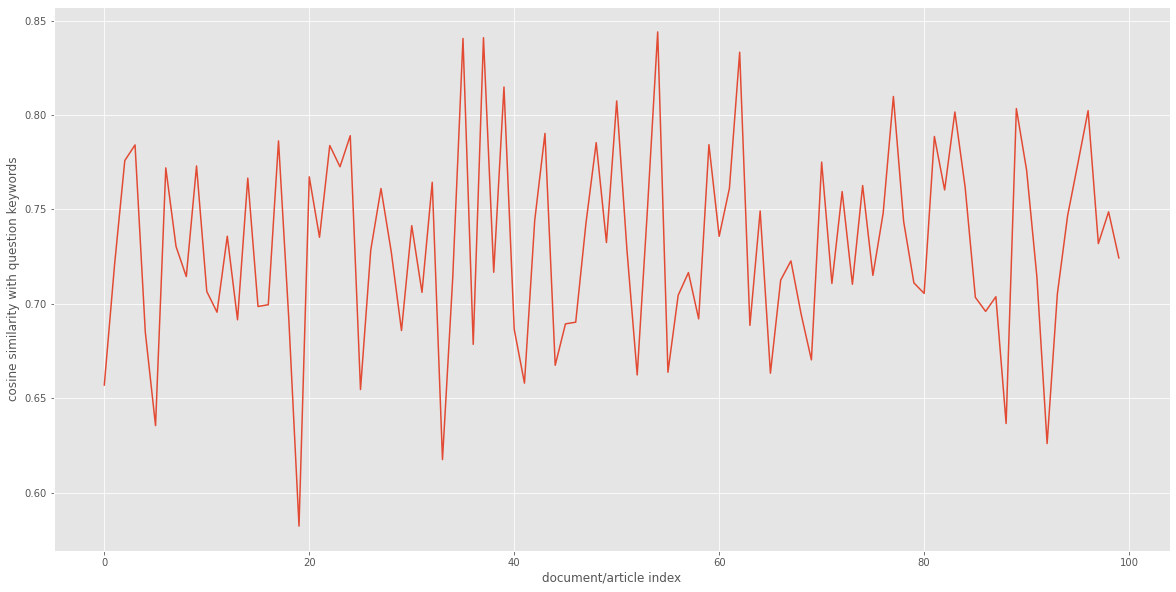

In [36]:
fig = plt.figure(figsize=(20,10))
plt.plot(cosine_similarity[:100])
plt.xlabel('document/article index')
plt.ylabel('cosine similarity with question keywords')

In [37]:
cosine_similarity = cosine_similarity.reshape(-1,)

In [38]:
reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
reqd_idxs

array([7833, 5918, 6924, 1100, 4679])

In [39]:
detect(df_covid_small.iloc[6141]['filtered_body_text'][:])

'en'

In [40]:
cosine_similarity[reqd_idxs]

array([       nan, 0.88856512, 0.88154848, 0.88072671, 0.87948861])

In [41]:
print("Articles for your question: ")
for idx in reqd_idxs:
    print(df_covid_small.iloc[idx]['title']+" by "+ df_covid_small.iloc[idx]['authors'])
    print(df_covid_small.iloc[idx]['filtered_body_text'][:1000]+"......")
    print("="*140)

Articles for your question: 
Genome Sequences of Rhinovirus C Isolates from Wisconsin Pediatric Respiratory Studies by Stephen Liggett, Yury Bochkov, Tressa Pappas, Robert Lemanske, James Gern, Naomi Sengamalay, Xuechu Zhao, Qi Su, Claire Fraser, Ann Palmenberg
each contiguous data set has been deposited at ddbjemblgenbank using the accession numbers listed below each unit described here is the first genome version of the sequence of that isolate co2 jn815248 jn837695 jn990703 jq245968 and jx025557 c03 jn798567 and jn990700 c04 jf781509 c06 jn815245 and jn990702 c07 jn798559 jn798570 jn837689 jq994495 and jx025556 c08 jq245964 and jq245973 c15 jn837688 c17 jn815240 jn815244 and jq837720 c22 jn621242 c25 jn837685 c26 jx193796 c28 jn798569 c32 jn798581 and jq994498 c36 jn541267 c38 jn837691 c40 jf781505 jn815251 and jq245963 c41 jn798565 c42 jq994500 c43 jn815249 jn837687 and jx074056 c45 jn837686 c49 jf907574 jn798566 and jn798568......
Thirty Years into the Genomics Era: Tumor Viruses 

# Text Summarisation

In [42]:
import heapq

In [43]:
#function to calculate weighted frequency of all words extracted
def weighted_freq(formatted_article_text,stopwords):
    word_frequencies = {}
    for word in nltk.word_tokenize(formatted_article_text):
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
    return word_frequencies

In [44]:
#function to rank sentences using weighted frequencies
def rank_sentences(sentence_list, word_frequencies):
    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]
    return sentence_scores

In [45]:
def print_summary(sentences):
    summary = ' '.join(sentences)
    print(summary+'\n')

In [46]:
def generate_summary(doc_indx):
    for idx in doc_indx:
        print("Summary for article: "+ df_covid_small.iloc[idx]['title'])
        #tokenize sentences
        sentence_list = nltk.sent_tokenize(df_covid_small.iloc[idx]['body_text'])
        stopwords = nltk.corpus.stopwords.words('english')
        #get preprocessed articles
        formatted_article_text = df_covid_small.iloc[idx]['filtered_body_text']
        #calculate weighted frequencies
        word_frequencies = weighted_freq(formatted_article_text,stopwords)
        #rank sentences
        sentence_scores = rank_sentences(sentence_list, word_frequencies)
        #generate summary
        summary_sentences = heapq.nlargest(8, sentence_scores, key=sentence_scores.get)
        #print summary
        print_summary(summary_sentences)

In [47]:
generate_summary(reqd_idxs)

Summary for article: Genome Sequences of Rhinovirus C Isolates from Wisconsin Pediatric Respiratory Studies
Each contiguous data set has been deposited at DDBJ/EMBL/GenBank using the accession numbers listed below.

Summary for article: Thirty Years into the Genomics Era: Tumor Viruses Led the Way
These cancer vaccines are produced by using recombinant DNA technology with defined viral DNA segments because of the difficulty of propagating these human tumor viruses in the laboratory. The first sequences were derived from RNA copied from the viral DNA, but researchers soon moved to sequencing the DNA itself. The breakthrough that allowed the sequencing of viral genomes (and later, larger cloned genomes) was the use of restriction endonucleases to manipulate and analyze DNA. The next year, the DNA sequence of the tumor virus SV40 was solved by groups headed by Sherman Weissman at Yale University and Walter Fiers in Belgium [7-8]. One of the first viral sequences solved revealed the startl

# K Nearest Neighbours Approach

In [48]:
class KNN_finder:
    def __init__(self, doc_embeddings, k=5):
        self.doc_embeddings = doc_embeddings
        self.k = k
        
    def update_k(self, k):
        self.k = k
    
    def get_euc_dist(self, query_vec):
        vec_diff = self.doc_embeddings - query_vec
        vec_dist = np.linalg.norm(vec_diff, axis=1)
        return vec_dist
    
    def get_k_nearest(self, query_vec):
        vec_dist = self.get_euc_dist(query_vec)
        reqd_idxs = np.argpartition(vec_dist, 5)[:5]
        reqd_idxs = reqd_idxs[np.argsort(vec_dist[reqd_idxs])]
        return reqd_idxs

In [49]:
knn = KNN_finder(doc_embeddings)
question = "What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes"
keywords = get_kw_from_question(question)
kw_embedding_vec = get_kw_embedding_vec(keywords)
best_5_indx = knn.get_k_nearest(kw_embedding_vec)

In [50]:
best_5_indx

array([5918, 1100, 4679, 6924, 4680])

In [51]:
for idx in best_5_indx:
    print(df_covid_small.iloc[idx]['title']+" by "+ df_covid_small.iloc[idx]['authors'])
    print(df_covid_small.iloc[idx]['body_text'][:1000]+"......")
    print("="*140)

Thirty Years into the Genomics Era: Tumor Viruses Led the Way by Daniel DiMaio, George Miller
The breakthrough that allowed the sequencing of viral genomes (and later, larger cloned genomes) was the use of restriction endonucleases to manipulate and analyze DNA. Bacterial cells synthesize restriction enzymes to defend themselves against invading foreign DNA, and these enzymes were first identified and characterized on the basis of their ability to cleave bacteriophage DNA.
The value of restriction enzymes was established by a series of pioneering studies by Daniel Nathans at Johns Hopkins and Paul Berg at Stanford on the genome of SV40, a small virus that normally infects monkeys. SV40 was discovered in tissue cultures of monkey kidney cells in which poliovirus vaccine was produced, and many vaccinated individuals were inadvertently inoculated with SV40 during early poliovirus vaccination programs.
Enhanced interest in SV40 lay in the fact that it and the closely related mouse polyomav

In [52]:
generate_summary(best_5_indx)

Summary for article: Thirty Years into the Genomics Era: Tumor Viruses Led the Way
These cancer vaccines are produced by using recombinant DNA technology with defined viral DNA segments because of the difficulty of propagating these human tumor viruses in the laboratory. The first sequences were derived from RNA copied from the viral DNA, but researchers soon moved to sequencing the DNA itself. The breakthrough that allowed the sequencing of viral genomes (and later, larger cloned genomes) was the use of restriction endonucleases to manipulate and analyze DNA. The next year, the DNA sequence of the tumor virus SV40 was solved by groups headed by Sherman Weissman at Yale University and Walter Fiers in Belgium [7-8]. One of the first viral sequences solved revealed the startling situation that the same piece of DNA could encode two proteins with entirely different amino acid sequences [34]. Extensive sequencing also resulted in the identification of multiple different types of human papi

# TF-IDF IMPLEMENTATION

In [53]:
final_data=df_covid_small.copy(500)
final_data
# calculating the df
#creating a set
DF = {}
#for i in range(len(final_data.iloc[0]['filtered_body_text'])):
tokens =nltk.word_tokenize(final_data.iloc[0]['filtered_body_text'])
tokens[0]
for i in range(len(tokens)):
    temp=tokens[i]
    try:
        DF[temp].add(i)
    except:
        DF[temp] = {i}
#DF

In [54]:
#for i in DF:
#    DF[i]=len(DF[i])
tokens = nltk.word_tokenize(final_data.iloc[0]['filtered_body_text'])
tokens
for i in DF:
    DF[i]=len(DF[i])
#DF

In [55]:
total_vocab=[x for x in DF]
len(total_vocab)

572

In [56]:
words_freq = words_freq_atleast_2(df_covid_small.iloc[0]['filtered_body_text'])

In [57]:
from nltk import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# computes tf idf similarity between query and documents in dataset with n being max number of retrieved documents
def compute_tf_idf_similarity(query, docs, n,index_store):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(docs)
    query = tfidf_vectorizer.transform([query])
    
    cosine_similarities = linear_kernel(query, tfidf).flatten()
#     related_docs_indices = cosine_similarities.argsort()[:-5:-1]
    related_docs_indices = (-cosine_similarities).argsort()[:n]
    
    res = []
    for i in range(0, len(related_docs_indices)):
        res.append(docs[related_docs_indices[i]])
        index_store.append(related_docs_indices[i])
        
    '''res_df = pd.DataFrame(res, columns=['text'])
    titles = []
    authors = []
    for j in range(0, len(res_df)):
        for i in range(0, len(relevant_corpus)):
            if(relevant_corpus['text'][i] == res_df['text'][j]):
                titles.append(relevant_corpus['title'][i])
                authors.append(relevant_corpus['authors'][i])
                
    res_df['title'] = titles
    res_df['authors'] = authors
    res_df = res_df[["title","authors", "text"]]'''
    return res

In [58]:
# path to corpus of data
#CORONAVIRUS_LIBRARY_PATH = '../input/CORD-19-research-challenge'
# path from which created csv is read
#RELEVANT_PAPERS_PATH = '../input/covid19csv/relevant_papers.csv'
#relevant_corpus = pd.read_csv(RELEVANT_PAPERS_PATH).loc[:]
pd.set_option('max_colwidth', 500)
#df = pd.DataFrame(relevant_corpus)
#docs = df['text'].tolist()
docs = final_data['filtered_body_text'].tolist()
query = "What is the evidence that livestock could be infected (field surveillance, genetic sequencing, receptor binding)? \
Evidence of whether farmers are infected, and whether farmers could have played a role in the origin."
index_store = []
results = compute_tf_idf_similarity(query, docs,5, index_store)
#summaries = summarize_results(results)
#display_output(query, results,summaries)
results
#text sumaarization below.
generate_summary(index_store)# this  will print the answer tot he question

Summary for article: Comparison between dairy cow disease incidence in data registered by farmers and in data from a disease-recording system based on veterinary reporting
Table 5 also shows the corresponding IRs and IPs for events with veterinary contact (according to the farmer) and for veterinary reported events in the DDD. Looking at veterinary reported events in the DDD that were identified in the farmers’ data, the event-level comparison was not significant (Table 3). Diagnosis-specific IRs and IPs are presented in Table 5
, for all disease events in the farmers’ data and in the DDD. For group-reported events where the farmer reported “all animals” to be affected, SDA data were used to identify all animals in the herd at that time. We found that 88% of all veterinary-reported events in the DDD (n
 = 1161) were identified in the farmers’ data. For several of the most common diagnoses, the rates and proportions for all events were significantly higher in farmers’ data than in the D

# Topic Modelling

In [59]:
def get_tokens(filtered_body_text):
    #tokenize the text
    tokens = nltk.word_tokenize(filtered_body_text)
    #print(tokens)
    #remove stop words
    tokens = list(filter(lambda x: x not in final_stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    #return words which have frequency greater than 1
    #print(tokens[:5])
    one_occur = np.array(list(filter(lambda x: x[1] < 5, Counter(tokens).most_common())))[:,0].flatten()
    tokens = list(filter(lambda x: x not in one_occur, tokens))
    #print(tokens)
    return tokens

In [60]:
import gensim

In [61]:
df_covid_small.head(5)

,paper_id,title,authors,abstract,body_text,filtered_body_text
0,PMC7405720,"Potential of combating transmission of COVID-19 using novel self-cleaning superhydrophobic surfaces: part II—thermal, chemical, and mechanical durability","Assem Elzaabalawy, S. Meguid",,"COVID-19 can be transmitted through airborne respiratory droplets, ejected as a result of coughing or sneezing through human contact with contaminated surfaces (Yang and Wang 2020; Gralinski and Menachery 2020). Recent studies by the National Institute of Allergy and Infectious Diseases (USA) have shown that the virus can infect fomites made of metals, polymers and recycled paper for days (Van Doremalen et al. 2020).\nSuperhydrophobic surfaces have recently gained popularity in the biomedica...",covid-19 can be transmitted through airborne respiratory droplets ejected as a result of coughing or sneezing through human contact with contaminated surfaces recent studies by the national institute of allergy and infectious diseases have shown that the virus can infect fomites made of metals polymers and recycled paper for days superhydrophobic surfaces have recently gained popularity in the biomedical sector due to their ability to possess blood repellency characteristics and reduce bacte...
1,PMC7091850,The impact of COVID-19 on the provision of donor hematopoietic stem cell products worldwide: collateral damage,"Jeff Szer, Daniel Weisdorf, Sergio Querol, Lydia Foeken, Alejandro Madrigal",,"The provision of donors for life-saving hematopoietic stem cell transplants is coordinated through registries and facilitated by the World Marrow Donor Association (WMDA), which operates a global database to find the best stem cell source. The database contains 36,214,535 donors and 790,357 cord blood units from 98 different registries in 53 different countries [1].\nThe currently accelerating rate of COVID-19 infection and the responses of governments and facilities have the potential to im...",the provision of donors for life-saving hematopoietic stem cell transplants is coordinated through registries and facilitated by the world marrow donor association which operates a global database to find the best stem cell source the database contains 36214535 donors and 790357 cord blood units from 98 different registries in 53 different countries the currently accelerating rate of covid-19 infection and the responses of governments and facilities have the potential to impact and interfere...
3,PMC7194468,Recent advances in influenza vaccines,"Graham Pawelec, Janet McElhaney",,"Despite the common perception that it is “only a flu”, seasonal influenza is a powerful pathogen responsible for many hundreds of thousands of deaths every year, especially of elderly people. It is somewhat puzzling that a highly contagious pathogen responsible for an estimated average of half a million fatalities every year is faced with such insouciance by most people. Indeed, globally, 300,000 to 700,000 people die from the consequences of respiratory complications of influenza each year,...",despite the common perception that it is only a flu seasonal influenza is a powerful pathogen responsible for many hundreds of thousands of deaths every year especially of elderly people it is somewhat puzzling that a highly contagious pathogen responsible for an estimated average of half a million fatalities every year is faced with such insouciance by most people indeed globally 300000 to 700000 people die from the consequences of respiratory complications of influenza each year with a hug...
4,PMC7096991,Guarding the frontiers: the biology of type III interferons,"Andreas Wack, Ewa Terczyńska-Dyla, Rune Hartmann",,"The type III IFN family was discovered by two teams1,2. The groups chose different naming conventions but subsequently agreed upon the IFN-λ nomenclature3. We use the current nomenclature here and include the now abandoned nomenclature in parentheses. We list protein names, but the names of their encoding genes are

In [62]:
final_df = df_covid_small.head(500).copy()

In [63]:
def array_of_tokens(df):
    processed_docs = []
    l = len(df)
    for i in range(l):
        if i % 100 == 0:
            print("Processing",i,"th of ",l)
        x = get_tokens(df.iloc[i]['filtered_body_text'])
        processed_docs.append(x)
    return processed_docs

In [64]:
def get_dictionary(docs):
    dictionary = gensim.corpora.Dictionary(docs)
    dictionary.filter_extremes(no_below=40, no_above=0.5, keep_n=10000)
    return dictionary
def get_corpus(dictionary):
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    return bow_corpus

In [65]:
def apply_lda(bow_corpus, num_topics, id2word, passes, workers):#, chunksize):
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=id2word, passes=passes, workers=workers)#, chunksize = chunksize)
    return lda_model
def print_topics(lda_model):
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))

In [66]:
def get_score_from_keyword(lda_model,keywords):
    scores = []
    bow_vector = dictionary.doc2bow(keywords)
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
        scores.append((score,index))
    return scores

In [67]:
def get_document_topics(lda_model,bow_corpus):
    return [lda_model.get_document_topics(item) for item in bow_corpus]

In [68]:
def index_of_topic_highest_score(scores):
    return scores[0][1]

def get_10_similar_docs(get_document_topics,doc_index):
    similar_docs = []
    for i,doc in enumerate(get_document_topics):
        for tup in doc:
            if tup[0] == doc_index:
                similar_docs.append((tup[1],i))
    similar_docs.sort(reverse = True)
    return similar_docs[:10]

def display_10_docs(similar_docs):
    for doc in similar_docs:
        print(df_covid_small.iloc[doc[1]]['title'])
        print(df_covid_small.iloc[doc[1]]['body_text'][:1000])
        print("===============================================================================================================")

In [69]:
#driver
processed_docs = array_of_tokens(final_df)

# model = apply_lda(corpus,10,dictionary,2,5,100)
# print_topics(model)
# scores = get_score_from_keyword(model,keywords)
# print(scores)

Processing 0 th of  500
Processing 100 th of  500
Processing 200 th of  500
Processing 300 th of  500
Processing 400 th of  500


In [70]:
dictionary = get_dictionary(processed_docs)
corpus = get_corpus(dictionary)

In [71]:
model = apply_lda(corpus,10,dictionary,2,10)
print_topics(model)
question = "What do we know about corona virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes"
keywords = get_kw_from_question(question)
scores = get_score_from_keyword(model,keywords)
print(scores)

Topic: 0 
Words: 0.049*"patient" + 0.044*"virus" + 0.039*"infection" + 0.030*"disease" + 0.021*"host" + 0.021*"viral" + 0.020*"human" + 0.018*"transmission" + 0.018*"cell" + 0.015*"case"
Topic: 1 
Words: 0.089*"virus" + 0.043*"viral" + 0.038*"infection" + 0.028*"respiratory" + 0.026*"protein" + 0.025*"sample" + 0.016*"patient" + 0.016*"rna" + 0.015*"result" + 0.015*"clinical"
Topic: 2 
Words: 0.036*"method" + 0.031*"data" + 0.031*"model" + 0.028*"result" + 0.025*"case" + 0.024*"number" + 0.023*"value" + 0.023*"patient" + 0.021*"time" + 0.019*"1"
Topic: 3 
Words: 0.077*"cell" + 0.044*"model" + 0.034*"infection" + 0.026*"disease" + 0.026*"protein" + 0.024*"mouse" + 0.018*"expression" + 0.017*"number" + 0.016*"lung" + 0.016*"result"
Topic: 4 
Words: 0.065*"protein" + 0.030*"binding" + 0.028*"vaccine" + 0.028*"interaction" + 0.022*"animal" + 0.021*"group" + 0.020*"cell" + 0.019*"domain" + 0.019*"virus" + 0.018*"1"
Topic: 5 
Words: 0.029*"protein" + 0.027*"cell" + 0.025*"disease" + 0.024*"c

In [72]:
doc_topics = get_document_topics(model,corpus)
relevant_docs = get_10_similar_docs(doc_topics,index_of_topic_highest_score(scores))
print(relevant_docs)
display_10_docs(relevant_docs)

[(0.9972886, 96), (0.9960691, 287), (0.9948852, 193), (0.9940776, 247), (0.9854802, 34), (0.9590836, 211), (0.95756567, 301), (0.94845015, 372), (0.92499, 242), (0.9097512, 480)]
Microbiology of Acute Otitis Media in Children with Tympanostomy Tubes: Prevalences of Bacteria and Viruses

Population. The study population consisted of 79 children who had AOM with otorrhea through the tympanostomy tube for <48 h before study entry. In 73% of cases, the otorrhea had appeared within 24 h of study entry. The median age of the study population was 21 months (range, 7–71 months). Before study entry, all except 1 had experienced symptoms of a concomitant viral-type respiratory infection for 1–7 days. Presenting symptoms were rhinitis and cough (in 97% and 87% of patients, respectively); 57% of the patients had both rhinitis and cough together with fever. Of the children, 51% had smoking parents, and 60% attended day care. The median number of episodes of otitis media within 6 months before tympa

In [73]:
generate_summary(list(map(lambda x: x[1], relevant_docs)))

Summary for article: Microbiology of Acute Otitis Media in Children with Tympanostomy Tubes: Prevalences of Bacteria and Viruses
The following viruses were sought only in samples negative for the aforementioned agents: human metapneumovirus (30 samples), adenovirus (28 samples), and parainfluenza virus types 1–4 (27 samples). Multiplex bacterial PCR was performed for all 16 MEF samples that did not yield bacteria by culture and for 17 samples with positive culture results. Previously, 10 studies have reported concomitant detection of bacteria and viruses from MEF samples of patients with AOM [3, 4, 16–23]. [25, 26] in Turku, who cultured respiratory syncytial virus from MEF and showed that viruses and bacteria may coexist in an acute middle ear infection. However, in the 16 negative samples, the presence of bacteria could be shown in 8 cases by multiplex PCR and in 2 cases by broad-range PCR. Viral antigens (respiratory syncytial virus, adenovirus, influenza A and B viruses, and parain

Nevertheless, a detection rate of 60% in NGS 2 was obtained using our NGS data analysis pipeline, approaching 70% in NGS 1. However, the direct recovery of viral genomes from clinical specimens using NGS methods has challenges, including noise from host or microbiota cells and the limited viral RNA quantities [16]. In addition to low viral copies, challenges to the recovery of viral genomes from clinical samples using NGS platforms include bacterial and human genome contamination. Correlations between NGS reads and PCR cycle threshold values have been observed, suggesting that NGS reads are suitable indicators of viral copy number [2, 26]. The two pooled samples exhibited different taxonomic compositions; for example, 86% of total reads belonged to the virus group in NGS 1, but only 6% in NGS 2. Our NGS data analysis method was applied to identify unknown viral pathogens directly from these clinical specimens and to obtain their genome sequences by iterative mapping. The NGS data analy

# Text similarity using sentence transformers

In [74]:
!pip install -U sentence-transformers

     |████████████████████████████████| 61 kB 6.5 MB/s eta 0:00:011
     |████████████████████████████████| 97.5 MB 63.1 MB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.4-py3-none-any.whl size=99825 sha256=24b3b7fd5d9d543de292a91cb78569c22922101a0aade95aaaa1b164e67ccf74
  Stored in directory: /Users/sdeshpande/Library/Caches/pip/wheels/04/b3/c1/719d094c255bb2b38185bf56252e4e5853a52ce53ff6af3488
Successfully built sentence-transformers


In [76]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')


  0%|          | 0.00/405M [00:00<?, ?B/s]
  0%|          | 32.8k/405M [00:00<55:57, 121kB/s]
  0%|          | 65.5k/405M [00:00<54:13, 125kB/s]
  0%|          | 98.3k/405M [00:00<49:24, 137kB/s]
  0%|          | 147k/405M [00:00<42:24, 159kB/s] 
  0%|          | 197k/405M [00:01<42:45, 158kB/s]
  0%|          | 246k/405M [00:01<37:43, 179kB/s]
  0%|          | 295k/405M [00:01<33:24, 202kB/s]
  0%|          | 360k/405M [00:01<29:54, 226kB/s]
  0%|          | 410k/405M [00:02<33:21, 202kB/s]
  0%|          | 475k/405M [00:02<29:11, 231kB/s]
  0%|          | 541k/405M [00:02<26:16, 257kB/s]
  0%|          | 573k/405M [00:02<28:26, 237kB/s]
  0%|          | 639k/405M [00:02<25:46, 262kB/s]
  0%|          | 705k/405M [00:03<27:55, 241kB/s]
  0%|          | 770k/405M [00:03<25:12, 267kB/s]
  0%|          | 803k/405M [00:03<50:49, 133kB/s]
  0%|          | 885k/405M [00:04<41:41, 162kB/s]
  0%|          | 967k/405M [00:04<33:59, 198kB/s]
  0%|          | 1.06M/405M [00:04<27:41, 243kB/s]
 

  8%|▊         | 33.5M/405M [00:27<02:20, 2.65MB/s]
  8%|▊         | 33.7M/405M [00:27<02:35, 2.39MB/s]
  8%|▊         | 34.1M/405M [00:28<02:39, 2.32MB/s]
  9%|▊         | 34.6M/405M [00:28<02:33, 2.41MB/s]
  9%|▊         | 35.0M/405M [00:28<02:29, 2.48MB/s]
  9%|▉         | 35.5M/405M [00:28<02:26, 2.52MB/s]
  9%|▉         | 36.0M/405M [00:28<02:24, 2.55MB/s]
  9%|▉         | 36.5M/405M [00:29<02:22, 2.59MB/s]
  9%|▉         | 37.0M/405M [00:29<02:20, 2.62MB/s]
  9%|▉         | 37.5M/405M [00:29<02:19, 2.64MB/s]
  9%|▉         | 38.0M/405M [00:29<02:19, 2.64MB/s]
 10%|▉         | 38.5M/405M [00:29<02:18, 2.66MB/s]
 10%|▉         | 38.8M/405M [00:30<03:14, 1.88MB/s]
 10%|▉         | 39.5M/405M [00:30<02:35, 2.36MB/s]
 10%|▉         | 39.8M/405M [00:30<02:46, 2.20MB/s]
 10%|▉         | 40.1M/405M [00:30<02:36, 2.33MB/s]
 10%|▉         | 40.3M/405M [00:30<02:59, 2.03MB/s]
 10%|█         | 40.6M/405M [00:30<03:07, 1.95MB/s]
 10%|█         | 40.9M/405M [00:30<03:00, 2.02MB/s]
 10%|█      

 18%|█▊        | 74.6M/405M [00:50<14:42, 375kB/s] 
 18%|█▊        | 74.8M/405M [00:50<14:15, 386kB/s]
 18%|█▊        | 74.9M/405M [00:50<12:30, 440kB/s]
 19%|█▊        | 75.0M/405M [00:51<11:42, 470kB/s]
 19%|█▊        | 75.2M/405M [00:51<09:34, 574kB/s]
 19%|█▊        | 75.5M/405M [00:51<07:39, 718kB/s]
 19%|█▊        | 75.9M/405M [00:51<06:14, 881kB/s]
 19%|█▉        | 76.1M/405M [01:00<1:03:53, 85.9kB/s]
 19%|█▉        | 76.2M/405M [01:01<1:03:09, 86.8kB/s]
 19%|█▉        | 76.3M/405M [01:01<48:38, 113kB/s]   
 19%|█▉        | 76.4M/405M [01:02<38:20, 143kB/s]
 19%|█▉        | 76.5M/405M [01:02<31:11, 176kB/s]
 19%|█▉        | 76.6M/405M [01:02<29:20, 187kB/s]
 19%|█▉        | 76.9M/405M [01:02<21:34, 254kB/s]
 19%|█▉        | 77.0M/405M [01:03<16:49, 325kB/s]
 19%|█▉        | 77.2M/405M [01:03<14:41, 372kB/s]
 19%|█▉        | 77.3M/405M [01:03<17:55, 305kB/s]
 19%|█▉        | 77.5M/405M [01:04<13:58, 391kB/s]
 19%|█▉        | 77.6M/405M [01:04<12:10, 448kB/s]
 19%|█▉        | 77.8

 24%|██▍       | 98.0M/405M [01:22<03:21, 1.52MB/s]
 24%|██▍       | 98.2M/405M [01:22<03:23, 1.51MB/s]
 24%|██▍       | 98.4M/405M [01:22<03:39, 1.40MB/s]
 24%|██▍       | 98.6M/405M [01:22<03:16, 1.56MB/s]
 24%|██▍       | 98.7M/405M [01:22<03:14, 1.57MB/s]
 24%|██▍       | 98.9M/405M [01:22<03:19, 1.54MB/s]
 24%|██▍       | 99.1M/405M [01:22<03:20, 1.52MB/s]
 24%|██▍       | 99.2M/405M [01:22<03:38, 1.40MB/s]
 25%|██▍       | 99.5M/405M [01:22<03:19, 1.53MB/s]
 25%|██▍       | 99.6M/405M [01:23<03:16, 1.55MB/s]
 25%|██▍       | 99.8M/405M [01:23<03:29, 1.46MB/s]
 25%|██▍       | 100M/405M [01:23<03:04, 1.66MB/s] 
 25%|██▍       | 100M/405M [01:23<03:04, 1.65MB/s]
 25%|██▍       | 100M/405M [01:23<03:07, 1.63MB/s]
 25%|██▍       | 101M/405M [01:23<03:09, 1.60MB/s]
 25%|██▍       | 101M/405M [01:23<03:22, 1.50MB/s]
 25%|██▍       | 101M/405M [01:23<03:03, 1.66MB/s]
 25%|██▍       | 101M/405M [01:24<03:03, 1.66MB/s]
 25%|██▌       | 101M/405M [01:24<03:14, 1.56MB/s]
 25%|██▌       | 10

 46%|████▋     | 188M/405M [01:40<00:38, 5.69MB/s]
 47%|████▋     | 188M/405M [01:40<00:36, 5.95MB/s]
 47%|████▋     | 189M/405M [01:40<00:36, 5.93MB/s]
 47%|████▋     | 190M/405M [01:40<00:37, 5.81MB/s]
 47%|████▋     | 191M/405M [01:40<00:34, 6.27MB/s]
 47%|████▋     | 191M/405M [01:40<00:37, 5.75MB/s]
 47%|████▋     | 192M/405M [01:40<00:33, 6.38MB/s]
 48%|████▊     | 193M/405M [01:41<00:34, 6.24MB/s]
 48%|████▊     | 193M/405M [01:41<00:35, 5.98MB/s]
 48%|████▊     | 194M/405M [01:41<00:32, 6.43MB/s]
 48%|████▊     | 195M/405M [01:41<00:34, 6.14MB/s]
 48%|████▊     | 196M/405M [01:41<00:33, 6.19MB/s]
 48%|████▊     | 196M/405M [01:41<00:32, 6.36MB/s]
 49%|████▊     | 197M/405M [01:41<00:34, 6.11MB/s]
 49%|████▉     | 198M/405M [01:41<00:44, 4.68MB/s]
 49%|████▉     | 199M/405M [01:42<00:36, 5.61MB/s]
 49%|████▉     | 199M/405M [01:42<00:37, 5.45MB/s]
 49%|████▉     | 200M/405M [01:42<00:39, 5.22MB/s]
 50%|████▉     | 201M/405M [01:42<00:40, 5.00MB/s]
 50%|████▉     | 201M/405M [01:

 66%|██████▌   | 268M/405M [01:59<00:46, 2.95MB/s]
 66%|██████▋   | 269M/405M [01:59<00:49, 2.75MB/s]
 66%|██████▋   | 269M/405M [01:59<00:44, 3.07MB/s]
 66%|██████▋   | 269M/405M [01:59<00:43, 3.11MB/s]
 67%|██████▋   | 270M/405M [01:59<00:45, 2.97MB/s]
 67%|██████▋   | 270M/405M [01:59<00:40, 3.37MB/s]
 67%|██████▋   | 271M/405M [01:59<00:42, 3.14MB/s]
 67%|██████▋   | 271M/405M [01:59<00:42, 3.14MB/s]
 67%|██████▋   | 271M/405M [02:00<00:39, 3.35MB/s]
 67%|██████▋   | 272M/405M [02:00<01:01, 2.16MB/s]
 67%|██████▋   | 272M/405M [02:02<05:09, 430kB/s] 
 67%|██████▋   | 273M/405M [02:02<03:45, 587kB/s]
 67%|██████▋   | 273M/405M [02:02<03:06, 709kB/s]
 67%|██████▋   | 273M/405M [02:03<03:17, 668kB/s]
 68%|██████▊   | 274M/405M [02:03<02:59, 733kB/s]
 68%|██████▊   | 274M/405M [02:03<02:51, 767kB/s]
 68%|██████▊   | 274M/405M [02:03<02:50, 768kB/s]
 68%|██████▊   | 274M/405M [02:04<04:06, 532kB/s]
 68%|██████▊   | 274M/405M [02:04<03:24, 640kB/s]
 68%|██████▊   | 274M/405M [02:04<03:11

 74%|███████▍  | 302M/405M [02:26<03:34, 483kB/s] 
 75%|███████▍  | 302M/405M [02:26<02:44, 626kB/s]
 75%|███████▍  | 302M/405M [02:26<02:16, 757kB/s]
 75%|███████▍  | 302M/405M [02:27<02:27, 698kB/s]
 75%|███████▍  | 302M/405M [02:27<02:41, 635kB/s]
 75%|███████▍  | 303M/405M [02:27<02:56, 581kB/s]
 75%|███████▍  | 303M/405M [02:27<03:00, 568kB/s]
 75%|███████▍  | 303M/405M [02:27<02:50, 599kB/s]
 75%|███████▍  | 303M/405M [02:28<02:48, 606kB/s]
 75%|███████▍  | 303M/405M [02:28<02:50, 598kB/s]
 75%|███████▍  | 303M/405M [02:28<02:49, 603kB/s]
 75%|███████▍  | 303M/405M [02:28<02:46, 614kB/s]
 75%|███████▍  | 303M/405M [02:28<02:41, 632kB/s]
 75%|███████▍  | 304M/405M [02:29<02:36, 649kB/s]
 75%|███████▍  | 304M/405M [02:29<02:20, 724kB/s]
 75%|███████▍  | 304M/405M [02:29<02:21, 718kB/s]
 75%|███████▌  | 304M/405M [02:29<02:24, 701kB/s]
 75%|███████▌  | 304M/405M [02:29<02:26, 692kB/s]
 75%|███████▌  | 304M/405M [02:30<02:28, 681kB/s]
 75%|███████▌  | 304M/405M [02:30<02:29, 676kB/s]

 77%|███████▋  | 314M/405M [02:54<06:55, 220kB/s]
 77%|███████▋  | 314M/405M [02:54<06:53, 222kB/s]
 77%|███████▋  | 314M/405M [02:55<07:04, 216kB/s]
 77%|███████▋  | 314M/405M [02:55<07:28, 204kB/s]
 77%|███████▋  | 314M/405M [02:55<06:58, 219kB/s]
 77%|███████▋  | 314M/405M [02:55<06:41, 228kB/s]
 77%|███████▋  | 314M/405M [02:56<08:41, 175kB/s]
 77%|███████▋  | 314M/405M [02:56<07:09, 213kB/s]
 77%|███████▋  | 314M/405M [02:56<07:48, 195kB/s]
 77%|███████▋  | 314M/405M [02:56<07:44, 196kB/s]
 77%|███████▋  | 314M/405M [02:56<07:17, 208kB/s]
 77%|███████▋  | 314M/405M [02:56<07:38, 199kB/s]
 78%|███████▊  | 314M/405M [02:57<07:05, 214kB/s]
 78%|███████▊  | 314M/405M [02:57<07:08, 212kB/s]
 78%|███████▊  | 314M/405M [02:57<06:51, 221kB/s]
 78%|███████▊  | 314M/405M [02:57<06:30, 233kB/s]
 78%|███████▊  | 314M/405M [02:57<06:16, 242kB/s]
 78%|███████▊  | 314M/405M [02:58<06:05, 248kB/s]
 78%|███████▊  | 314M/405M [02:58<05:59, 252kB/s]
 78%|███████▊  | 314M/405M [02:58<06:45, 224kB/s]


 81%|████████▏ | 330M/405M [03:18<00:28, 2.66MB/s]
 82%|████████▏ | 330M/405M [03:18<00:26, 2.80MB/s]
 82%|████████▏ | 331M/405M [03:18<00:26, 2.80MB/s]
 82%|████████▏ | 331M/405M [03:18<00:23, 3.21MB/s]
 82%|████████▏ | 332M/405M [03:18<00:24, 3.01MB/s]
 82%|████████▏ | 332M/405M [03:18<00:23, 3.06MB/s]
 82%|████████▏ | 332M/405M [03:18<00:22, 3.22MB/s]
 82%|████████▏ | 333M/405M [03:19<00:22, 3.21MB/s]
 82%|████████▏ | 333M/405M [03:19<00:19, 3.66MB/s]
 82%|████████▏ | 334M/405M [03:19<00:20, 3.48MB/s]
 82%|████████▏ | 334M/405M [03:19<00:20, 3.52MB/s]
 83%|████████▎ | 334M/405M [03:19<00:19, 3.71MB/s]
 83%|████████▎ | 335M/405M [03:19<00:19, 3.70MB/s]
 83%|████████▎ | 336M/405M [03:19<00:16, 4.21MB/s]
 83%|████████▎ | 336M/405M [03:19<00:17, 4.00MB/s]
 83%|████████▎ | 336M/405M [03:19<00:17, 4.04MB/s]
 83%|████████▎ | 337M/405M [03:20<00:16, 4.17MB/s]
 83%|████████▎ | 337M/405M [03:20<00:17, 3.94MB/s]
 83%|████████▎ | 338M/405M [03:20<00:22, 3.02MB/s]
 83%|████████▎ | 338M/405M [03:

 92%|█████████▏| 375M/405M [03:42<00:24, 1.27MB/s]
 93%|█████████▎| 375M/405M [03:43<00:20, 1.46MB/s]
 93%|█████████▎| 375M/405M [03:43<00:20, 1.44MB/s]
 93%|█████████▎| 375M/405M [03:43<00:23, 1.29MB/s]
 93%|█████████▎| 375M/405M [03:43<00:20, 1.48MB/s]
 93%|█████████▎| 376M/405M [03:43<00:20, 1.47MB/s]
 93%|█████████▎| 376M/405M [03:43<00:22, 1.32MB/s]
 93%|█████████▎| 376M/405M [03:43<00:19, 1.50MB/s]
 93%|█████████▎| 376M/405M [03:43<00:19, 1.47MB/s]
 93%|█████████▎| 376M/405M [03:44<00:21, 1.33MB/s]
 93%|█████████▎| 377M/405M [03:44<00:18, 1.53MB/s]
 93%|█████████▎| 377M/405M [03:44<00:19, 1.49MB/s]
 93%|█████████▎| 377M/405M [03:44<00:21, 1.32MB/s]
 93%|█████████▎| 377M/405M [03:44<00:20, 1.36MB/s]
 93%|█████████▎| 377M/405M [03:44<00:19, 1.42MB/s]
 93%|█████████▎| 378M/405M [03:45<00:19, 1.44MB/s]
 93%|█████████▎| 378M/405M [03:45<00:18, 1.48MB/s]
 93%|█████████▎| 378M/405M [03:45<00:17, 1.51MB/s]
 93%|█████████▎| 379M/405M [03:45<00:17, 1.51MB/s]
 94%|█████████▎| 379M/405M [03:

 99%|█████████▉| 401M/405M [04:04<00:10, 368kB/s]
 99%|█████████▉| 402M/405M [04:04<00:09, 405kB/s]
 99%|█████████▉| 402M/405M [04:04<00:08, 415kB/s]
 99%|█████████▉| 402M/405M [04:04<00:07, 444kB/s]
 99%|█████████▉| 402M/405M [04:05<00:07, 467kB/s]
 99%|█████████▉| 402M/405M [04:05<00:06, 482kB/s]
 99%|█████████▉| 402M/405M [04:05<00:06, 495kB/s]
 99%|█████████▉| 402M/405M [04:05<00:05, 562kB/s]
 99%|█████████▉| 402M/405M [04:05<00:05, 552kB/s]
 99%|█████████▉| 402M/405M [04:05<00:05, 535kB/s]
 99%|█████████▉| 402M/405M [04:06<00:05, 535kB/s]
 99%|█████████▉| 403M/405M [04:06<00:05, 534kB/s]
 99%|█████████▉| 403M/405M [04:06<00:04, 533kB/s]
 99%|█████████▉| 403M/405M [04:06<00:04, 533kB/s]
 99%|█████████▉| 403M/405M [04:06<00:04, 532kB/s]
 99%|█████████▉| 403M/405M [04:07<00:04, 473kB/s]
 99%|█████████▉| 403M/405M [04:07<00:04, 485kB/s]
 99%|█████████▉| 403M/405M [04:07<00:03, 549kB/s]
 99%|█████████▉| 403M/405M [04:07<00:04, 482kB/s]
100%|█████████▉| 403M/405M [04:07<00:03, 538kB/s]


In [77]:
final_df = df_covid_small.head(500).copy()

In [78]:
np.array(model.encode(['a'])).shape

(1, 768)

In [79]:
np.array(model.encode(nltk.sent_tokenize(final_df.iloc[0]['filtered_body_text']))).shape

(1, 768)

In [80]:
doc_embeddings = np.zeros((len(final_df),768))
norms_doc_embeddings = np.zeros((len(final_df),1))
for i in range(len(final_df)):
    if i % 100 == 0:
        print("working on "+str(i)+"th document")
    doc_embedding_vec = np.array(model.encode(nltk.sent_tokenize(final_df.iloc[i]['filtered_body_text'])))
    doc_embedding_vec = doc_embedding_vec.sum(axis=0)
    doc_embedding_vec /= len(nltk.sent_tokenize(final_df.iloc[i]['filtered_body_text']))
    norms_doc_embeddings[i,:] = np.sqrt(np.dot(doc_embedding_vec,doc_embedding_vec.T))
    doc_embeddings[i,:] = doc_embedding_vec

working on 0th document
working on 100th document
working on 200th document
working on 300th document
working on 400th document


In [81]:
question = "What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes"
ques_embedding_vec = np.array(model.encode([question]))
norm_ques_embedding = np.sqrt(np.dot(ques_embedding_vec, ques_embedding_vec.T))

In [82]:
norm_prods = norms_doc_embeddings * norm_ques_embedding
dot_prod = np.dot(doc_embeddings, ques_embedding_vec.T)
cosine_similarity = dot_prod / norm_prods

In [83]:
cosine_similarity = cosine_similarity.reshape(-1,)
reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
reqd_idxs

array([384,  77, 112, 346,  27])

In [84]:
print("Articles for your question: ")
for idx in reqd_idxs:
    print(final_df.iloc[idx]['title']+" by "+ final_df.iloc[idx]['authors'])
    print(final_df.iloc[idx]['body_text'][:1000]+"......")
    print("="*140)

Articles for your question: 
RNA Viruses: RNA Roles in Pathogenesis, Coreplication and Viral Load by Palmiro Poltronieri, Binlian Sun, Massimo Mallardo
Human diseases causing RNA viruses include Orthomyxoviruses, Hepatitis C Virus (HCV), Ebola disease, SARS, influenza, polio measles and retrovirus including adult Human T-cell lymphotropic virus type 1 (HTLV-1) and human immunodeficiency virus (HIV). RNA viruses have RNA as genetic material, that may be a single-stranded RNA or a double stranded RNA. Viruses may exploit the presence of RNA-dependent RNA polymerases for replication of their genomes or, in retroviruses, with two copies of single strand RNA genomes, reverse transcriptase produces viral DNA which can be integrated into the host DNA under its integrase function. Studies showed that endogenous retroviruses are long-terminal repeat (LTR)-type retroelements that account for approximately 10% of human or murine genomic DNA. 
Among human retroviruses, HIV-1 is a lentivirus with a

In [85]:
generate_summary(reqd_idxs)

Summary for article: RNA Viruses: RNA Roles in Pathogenesis, Coreplication and Viral Load
RNA viruses have RNA as genetic material, that may be a single-stranded RNA or a double stranded RNA. RNA cap methylases are cellular factors that regulate post transcriptional HIV-1 RNA expression in order to produce a viral mRNA camouflaged by cellular mRNA showing a 7-methylguanosine (m7G) cap. The HIV-1 RNA genome is associated to the nucleocapsid protein (NC) and to viral enzymes, thus it is “protected” within the viral capsid mainly formed by the p24 protein. Host miRNAs can modulate HIV replication either directly by targeting HIV RNA, or targeting the mRNAs that encode host cell factors relevant to HIV replication. Their role is in the amplification of signals such as RNA primed RNA amplification, and the spreading of anti-viral RNA interference mechanism. Among human retroviruses, HIV-1 is a lentivirus with an RNA genome formed by two copies of a single-stranded, positive-sense RNA. In ca

In [86]:
def compute_cosine_get_idxs(norms_doc_embeddings, norm_ques_embedding, ques_embedding_vec, doc_embeddings):
    norm_prods = norms_doc_embeddings * norm_ques_embedding
    dot_prod = np.dot(doc_embeddings, ques_embedding_vec.T)
    cosine_similarity = dot_prod / norm_prods
    cosine_similarity = cosine_similarity.reshape(-1,)
    reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
    reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
    return reqd_idxs

In [87]:
question = "What about Animal host and any evidence of continued spill over to humans, Socioeconomic and behavioral risk factors for this spill over?"
ques_embedding_vec = np.array(model.encode([question]))
norm_ques_embedding = np.sqrt(np.dot(ques_embedding_vec, ques_embedding_vec.T))
reqd_idxs = compute_cosine_get_idxs(norms_doc_embeddings, norm_ques_embedding, ques_embedding_vec, doc_embeddings)
print("Articles for your question: ")
for idx in reqd_idxs:
    print(final_df.iloc[idx]['title']+" by "+ final_df.iloc[idx]['authors'])
    print(final_df.iloc[idx]['body_text'][:1000]+"......")
    print("="*140)

Articles for your question: 
The Global Threats from Naturally Occurring Infectious Diseases by Vladan Radosavljevic, Ines Banjari, Goran Belojevic, Alessandro Mancon, Davide Mileto, Maria Gismondo
Nowadays, when speaking about Biological risk we have to take in account a broad range of possible scenarios, varying from the simple exposure to a microorganism responsible for an infection to an intentional release of biological agents to cause epidemics.
Specifically, the wild spectrum of these risks can be attributable to different events with dissimilar levels of intent: natural occurring, unintended and deliberate (Fig.3.1).

The category of events naturally occurring is represented by all the naturally occurring infectious diseases of humans, animals and plants at national and/or international levels, jointly with the re-emerging ones often responsible of outbreaks that occur cyclically over time.
The unintended events represent a wild category in which it is possible identified diffe

In [88]:
generate_summary(reqd_idxs)

Summary for article: The Global Threats from Naturally Occurring Infectious Diseases
The second case regards an environment accidental release of biological agents due to an error in effluent control of laboratories in Europe regard the release of Foot-and-mouth disease virus. Emerging and re-emerging infectious diseases are a main global concern, since many of them involve highly hazardous pathogens or a very large population. Among the accidental release of biological agents occurred over the years, two cases are certainly noteworthy. Subsequently the occurrence of a biological, local and/or national institutions implement an emergency plan as first response throw specific preparedness strategies with the increasing of medical resources and infrastructures. Ebola virus belongs to Filoviridae family, which also includes Marburg virus: these pathogens are known to be highly infectious and to cause severe syndromes characterized by hemorrhages. Similarly, Re-emerging infectious diseases